In [37]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_percentage_error


ModuleNotFoundError: No module named 'xgboost'

In [33]:
df = pd.read_csv("../data/Kangaroo.csv")

In [ ]:
# Select important features
#features = ['price', 'subtype', 'bedroomCount', 'landSurface', 
            'facedeCount', 'bathroomCount', 'type', 'province', 'epcScore']

Index(['type', 'subtype', 'bedroomCount', 'bathroomCount', 'province',
       'locality', 'postCode', 'habitableSurface', 'buildingCondition',
       'toiletCount', 'hasSwimmingPool', 'epcScore', 'price'],
      dtype='object')

In [ ]:
# Drop rows where price is missing
#df_model = df[features].dropna(subset=['price'])  


In [15]:
df_model.shape

(76370, 8)

In [14]:
# check for missing values 
#  Percentage of missing values
missing_count = df_model.isnull().sum()
missing_pct   = (missing_count / len(df) * 100).round(2)

missing_summary = pd.DataFrame({
    'missing_count': missing_count,
    'missing_pct'  : missing_pct
}).sort_values('missing_pct', ascending=False)

print(missing_summary)  

                missing_count  missing_pct
terraceSurface          47772        59.44
landSurface             36833        45.83
facedeCount             23136        28.79
bathroomCount            9705        12.08
bedroomCount             2820         3.51
price                       0         0.00
type                        0         0.00
province                    0         0.00


### test1: for simple case

Mean Absolute Error (MAE): 219816.02 EUR


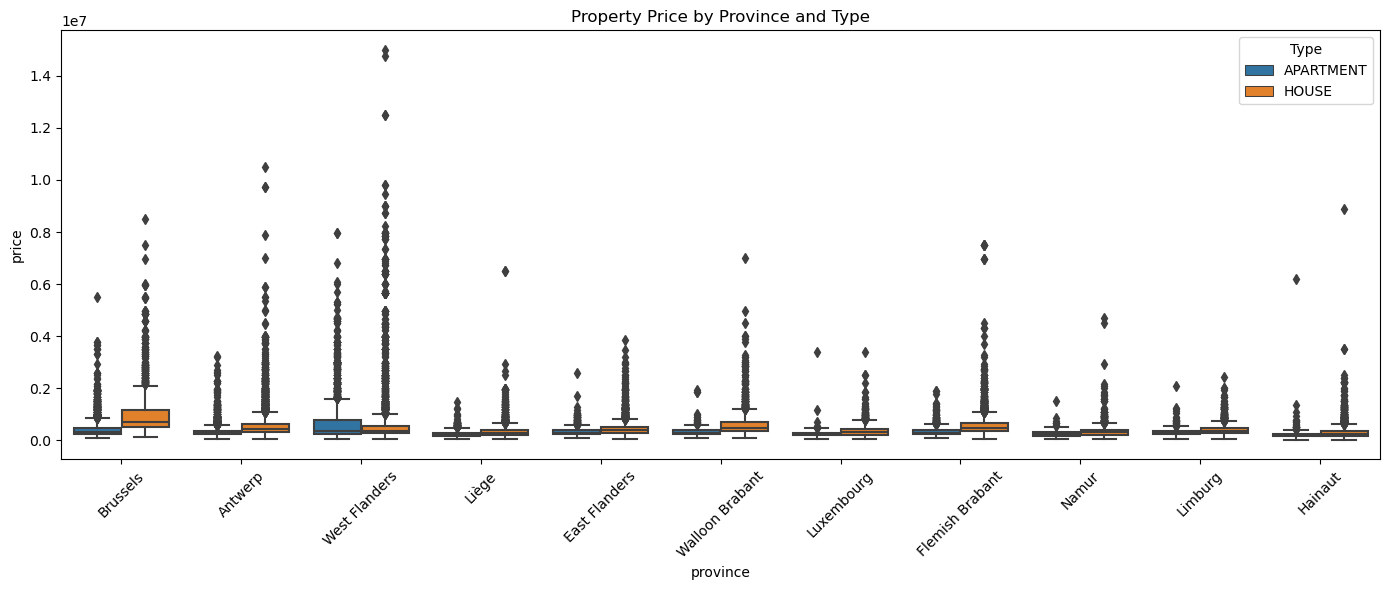

In [ ]:
# 2. Select features for modeling
features = ['bedroomCount', 'facedeCount', 'type',
            'bathroomCount', 'province'] 
target = 'price'

# Drop rows with missing values in selected features or target
df_model = df[features + [target]].dropna()

# 3. Define preprocessing
numeric_features = ['bedroomCount', 'facedeCount', 'bathroomCount']
categorical_features = ['province', 'type']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# 4. Create a pipeline with preprocessing and linear regression
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# 5. Train/test split
X = df_model[features]
y = df_model[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 6. Train the model
model.fit(X_train, y_train)

# 7. Predict and evaluate
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae:.2f} EUR")
mape = mean_absolute_percentage_error(y_test_original, y_pred_original)
print(f"Mean Absolute Percentage Error (MAPE): {mape * 100:.2f}%")

# 8. Optional: Visualize province + type vs price
plt.figure(figsize=(14, 6))
sns.boxplot(data=df_model, x='province', y='price', hue='type')
plt.xticks(rotation=45)
plt.title("Property Price by Province and Type")
plt.legend(title='Type')
plt.tight_layout()
plt.show()

In [ ]:
def map_postcode_to_region(postcode):
    if 1000 <= postcode <= 1299:
        return 'Brussels'
    elif 1300 <= postcode <= 1499 or 1500 <= postcode <= 1999 or 3000 <= postcode <= 3499:
        return 'Flemish Brabant'
    elif 2000 <= postcode <= 2999:
        return 'Antwerp'
    elif 3500 <= postcode <= 3999:
        return 'Limburg'
    elif 9000 <= postcode <= 9999:
        return 'East Flanders'
    elif 8000 <= postcode <= 8999:
        return 'West Flanders'
    elif 4000 <= postcode <= 4999:
        return 'Liège'
    elif 5000 <= postcode <= 5999:
        return 'Namur'
    elif 6000 <= postcode <= 6999:
        return 'Hainaut'
    elif 7000 <= postcode <= 7999:
        return 'Hainaut'
    elif 6600 <= postcode <= 6999:
        return 'Luxembourg'
    else:
        return 'Unknown'

# --- Apply mapping ---
df['region'] = df['postCode'].apply(map_postcode_to_region)

# --- Filter dataset to keep important features and drop rows with missing target ---
features = ['bedroomCount', 'terraceSurface', 'landSurface', 'facedeCount',
            'bathroomCount', 'type', 'province', 'region']
df_model = df[features + ['price']].dropna(subset=['price'])

# --- Fill missing values in numeric columns with median ---
numeric_features = ['bedroomCount', 'terraceSurface', 'landSurface', 'facedeCount', 'bathroomCount']
categorical_features = ['type', 'province', 'region']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# --- ColumnTransformer to apply transformations ---
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# --- Define target and features ---
df_model['log_price'] = np.log1p(df_model['price'])  # log transform to reduce skew
y = df_model['log_price']
X = df_model[features]

# --- Split dataset ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Build Pipeline with different models ---

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(n_estimators=100, random_state=42))
])


model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(n_estimators=100, random_state=42))
])

# --- Train model ---
model.fit(X_train, y_train)

# --- Predict and evaluate ---
y_pred = model.predict(X_test)
y_pred_original = np.expm1(y_pred)  # inverse log1p to get original prices
y_test_original = np.expm1(y_test)

mae = mean_absolute_error(y_test_original, y_pred_original)
print(f"Mean Absolute Error (MAE): {mae:,.2f} EUR")


Mean Absolute Error (MAE): 151,805.04 EUR
